In [7]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import glob

exclusion_list = ['p14', 'p16'] #@param
is_window_normalization = False #@param{type: "boolean"}

# Function to load and preprocess the dataset for CNN input, with subfolder-specific labeling
def normalize(raw_data):
  mean = np.mean(raw_data, axis=0)
  std = np.std(raw_data, axis=0)
  normalized_data = (raw_data - mean) / std
  return normalized_data

def load_and_preprocess_data(data_path):
    data = []
    labels = []
    users = []
    sessions = []

    # Walk through the folder structure
    for participant_folder in os.listdir(data_path):
        participant_path = os.path.join(data_path, participant_folder)
        user = os.path.basename(participant_path)
        if user in exclusion_list:
          continue
        if os.path.isdir(participant_path):
            # Go through each gesture folder
            for session_folder in os.listdir(participant_path):
                session = session_folder.split('_')[-1]
                session_path = os.path.join(participant_path, session_folder)

                gesture_labels = []
                for gesture_folder in os.listdir(session_path):
                    gesture_path = os.path.join(session_path, gesture_folder)
                    gesture_label = gesture_folder
                    if gesture_folder.endswith('p'):
                      for sub_gesture_folder in os.listdir(gesture_path):
                        sub_gesture_label = gesture_label
                        if "start" in sub_gesture_folder:
                          sub_gesture_label += 's'
                        elif "release" in sub_gesture_folder:
                          sub_gesture_label += 'r'
                        sub_gesture_path = os.path.join(gesture_path, sub_gesture_folder)
                        gesture_labels.append((sub_gesture_label, sub_gesture_path))
                    else:
                      gesture_labels.append((gesture_label, gesture_path))
                for gesture_label, gesture_path in gesture_labels:
                    if os.path.isdir(gesture_path):
                      npy_files = []
                      for pattern in ['/*.npy', '/*/*.npy']:
                        npy_files.extend(glob.glob(gesture_path+pattern))
                      real = np.array([])
                      imag = np.array([])
                      for npy_file in npy_files:
                        if 'real' in npy_file:
                          real = np.load(npy_file)
                        elif 'imag' in npy_file:
                          imag = np.load(npy_file)
                      if gesture_label == 'ip':
                          print(user, session)
                          continue
                      for window_i in range(real.shape[0]):
                        window_data = np.concatenate([real[window_i, :, :], imag[window_i, :, :]], axis=1)
                        if is_window_normalization:
                          window_data = normalize(window_data)

                        # Append data and corresponding label
                        data.append(window_data)
                        labels.append(gesture_label)
                        users.append(user)
                        sessions.append(session)

                        # end of window
                      # end of gesture
    return np.array(data), np.array(labels), np.array(users), np.array(sessions)

# Path to the extracted dataset
data_path = '/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/ML_input_data_resource/dataset_aug'

# Load and preprocess the data
data, labels, users, sessions = load_and_preprocess_data(data_path)
print(data.shape)
label_set = np.unique(labels)
print(label_set)
print(np.unique(users))
print(np.unique(sessions))

# Convert labels to indices
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
indexed_labels = np.array([label_to_index[label] for label in labels])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, indexed_labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_to_index))
y_test = to_categorical(y_test, num_classes=len(label_to_index))


(38434, 60, 12)
['id' 'ipr' 'ips' 'mpr' 'mps' 'sl' 'sr']
['p1' 'p10' 'p11' 'p12' 'p13' 'p15' 'p17' 'p18' 'p2' 'p3' 'p4' 'p5' 'p6'
 'p7' 'p8' 'p9']
['1' '2' '3' 'idle' 'sl' 'sr']


In [4]:
#@title CNN Modeling - 80/20

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


model = Sequential()
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(60,
12)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_set), activation='softmax'))


# Define the path to save the best model
checkpoint_filepath = '/tmp/best_model.keras'

# Create a ModelCheckpoint callback to save the model with the lowest validation loss
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
    verbose=1,
    save_best_only=True,
    mode='max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc


961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6252 - loss: 1.0215
Epoch 1: val_accuracy improved from -inf to 0.75244, saving model to /tmp/best_model.keras
961/961 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6253 - loss: 1.0213 - val_accuracy: 0.7524 - val_loss: 0.6542
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7490 - loss: 0.6438


0.7524392008781433

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7490 - loss: 0.6438
[0.6541728973388672, 0.7524392008781433]
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


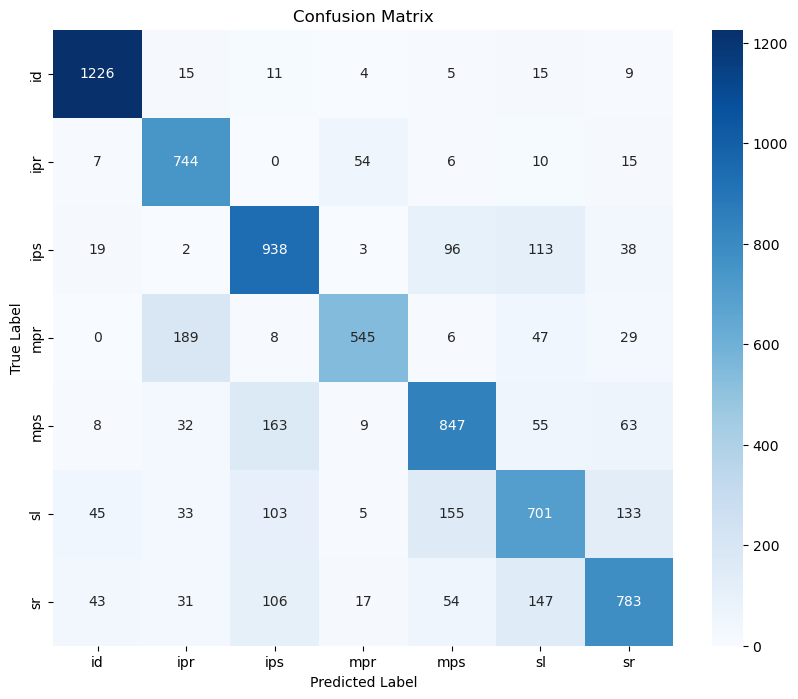

In [5]:
#@title Visualization
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
best_model = tf.keras.models.load_model('/tmp/best_model.keras')
print(best_model.evaluate(X_test, y_test))
# Convert y_test from one-hot encoding to single class labels (for confusion matrix)
y_test_labels = np.argmax(y_test, axis=1)

# Make predictions using the trained model
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


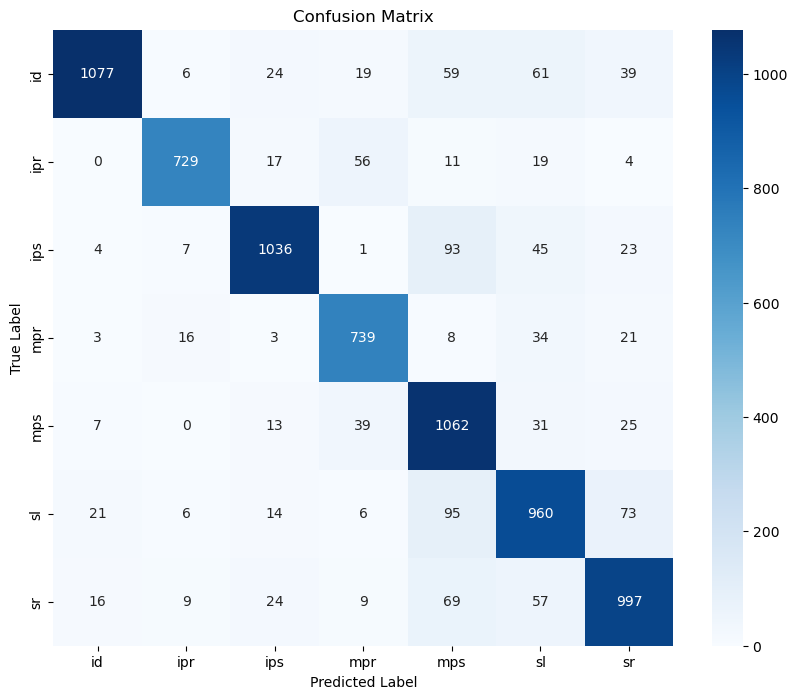

In [8]:
#@title Visualization
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf 
best_model = tf.keras.models.load_model("/home/ubuntu/paper_arm_model/best_model/best_gesture_model.h5")
# print(best_model.evaluate(X_test, y_test))
# Convert y_test from one-hot encoding to single class labels (for confusion matrix)
y_test_labels = np.argmax(y_test, axis=1)

# Make predictions using the trained model
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

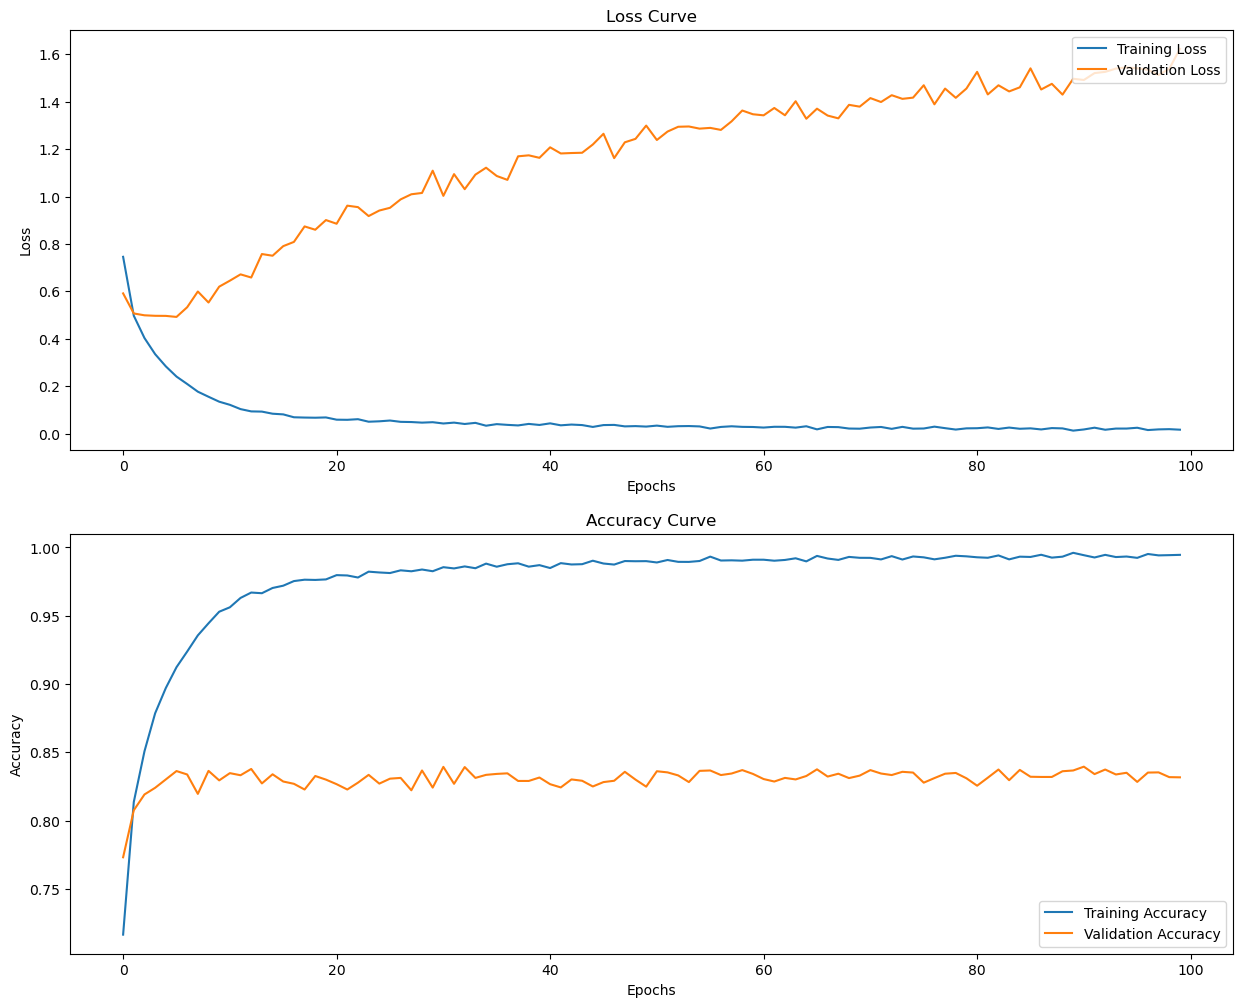

'/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/ML_input_data_resource/dataset_aug/best_model.keras'

In [5]:
#@title Plots
import matplotlib.pyplot as plt
import shutil

# Assuming `history` is the variable that stores the training history from model.fit()

# Create subplots for loss and accuracy curves
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

# Plot the training and validation loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

# Plot the training and validation accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')

# Display the plots
plt.show()

# Copy the best model file using shutil
shutil.copyfile('/tmp/best_model.keras', '/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/ML_input_data_resource/dataset_aug/best_model.keras')


In [7]:
#@title LOSO

import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

is_fewshot_finetuning = True #@param{type: "boolean"}
is_whole_sesion_finetuning = True #@param{type: "boolean"}

num_epoch_train = 2 #@param
num_epoch_finetune = 10 #@param
num_window_finetune = 1 #@param

# Assume data, labels, and users (user IDs) are available from earlier preprocessing
# data: The input data (X)
# labels: The target labels (y)
# users: User or participant IDs corresponding to each data point

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(indexed_labels, num_classes=len(label_set))

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()

logo_session = LeaveOneGroupOut()

# Prepare to store accuracy from each fold
fold_accuracies = []

LOSO_result = {}

# Loop over each fold in LOSO
for train_index, test_index in logo.split(data, labels_one_hot, groups=users):
    # Split data into training and testing sets for the current fold
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels_one_hot[train_index], labels_one_hot[test_index]

    model = Sequential()
    model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(60,
    12)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(label_set), activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Define the path to save the best model
    checkpoint_filepath = f'/tmp/{users[test_index][0]}_best_model.keras'

    # Create a ModelCheckpoint callback to save the model with the lowest validation loss
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
        verbose=1,
        save_best_only=True,
        mode='max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
    )

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=num_epoch_train, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

    if is_fewshot_finetuning:
      for fs_train_index, fs_test_index in logo_session.split(X_test, y_test, groups=sessions[test_index]):
        fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index]
        fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index]
        # print(f"LOSO session: {len(used_sessions)}")
        # print(f"LOSO session: {labels[test_index][fs_test_index]}")
        if not is_whole_sesion_finetuning:
          used_sessions = sessions[test_index][fs_test_index]
          labels_unique, unique_idx = np.unique(labels[test_index][fs_test_index], return_index=True)
          used_idx = []
          for i, idx in enumerate(unique_idx):
            used_idx.extend(list(range(idx, idx+num_window_finetune)))

          fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index][used_idx]
          fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index][used_idx]
        fs_history = model.fit(fs_X_test, fs_y_test, epochs=num_epoch_finetune, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])
        break

    # Evaluate the model
    cur_best_model = tf.keras.models.load_model(checkpoint_filepath)
    test_loss, test_acc = cur_best_model.evaluate(X_test, y_test)
    shutil.copyfile(checkpoint_filepath, f'/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/ML_input_data_resource/dataset_aug/{users[test_index][0]}_best_model.keras')


    # Save the test accuracy for this fold
    fold_accuracies.append(test_acc)
    print(f"LOSO user: {users[test_index]}")
    print(f"Fold Accuracy: {test_acc} loss: {test_loss}")
    LOSO_result[users[test_index][0]] = (test_acc, test_loss)

# Calculate the average accuracy across all folds
avg_accuracy = np.mean(fold_accuracies)
print(f"Average LOSO Accuracy: {avg_accuracy}")

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1050/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6443 - loss: 0.9366
Epoch 1: val_accuracy improved from -inf to 0.69297, saving model to /tmp/p1_best_model.keras
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6446 - loss: 0.9359 - val_accuracy: 0.6930 - val_loss: 0.8087
Epoch 2/2
1048/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8062 - loss: 0.5058
Epoch 2: val_accuracy improved from 0.69297 to 0.71701, saving model to /tmp/p1_best_model.keras
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8062 - loss: 0.5057 - val_accuracy: 0.7170 - val_loss: 0.8661
Epoch 1/10
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8143 - loss: 0.5679
Epoch 1: val_accuracy improved from 0.71701 to 0.93787, saving model to /tmp/p1_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8258 - loss: 0.5351 - val_accuracy: 0.9379 - val_loss: 0.1839
Epoch 2/10
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9704 - loss: 0.1130
Epoch 2: val_acc

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1049/1058 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6512 - loss: 0.9298
Epoch 1: val_accuracy improved from -inf to 0.67565, saving model to /tmp/p10_best_model.keras
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6518 - loss: 0.9281 - val_accuracy: 0.6756 - val_loss: 0.9088
Epoch 2/2
1054/1058 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8061 - loss: 0.5121
Epoch 2: val_accuracy did not improve from 0.67565
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8062 - loss: 0.5121 - val_accuracy: 0.6188 - val_loss: 1.1528
Epoch 1/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7997 - loss: 0.5329
Epoch 1: val_accuracy improved from 0.67565 to 0.92994, saving model to /tmp/p10_best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8080 - loss: 0.5127 - val_accuracy: 0.9299 - val_loss: 0.3548
Epoch 2/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9875 - loss: 0.0482
Epoch 2: val_accuracy improved from 0.92994 to 0.93631, savi

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1045/1047 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6533 - loss: 0.9406
Epoch 1: val_accuracy improved from -inf to 0.40310, saving model to /tmp/p11_best_model.keras
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6535 - loss: 0.9400 - val_accuracy: 0.4031 - val_loss: 2.0617
Epoch 2/2
1044/1047 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8216 - loss: 0.4750
Epoch 2: val_accuracy did not improve from 0.40310
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8216 - loss: 0.4750 - val_accuracy: 0.3947 - val_loss: 2.5910
Epoch 1/10
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6608 - loss: 0.9797
Epoch 1: val_accuracy improved from 0.40310 to 0.67198, saving model to /tmp/p11_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6857 - loss: 0.9013 - val_accuracy: 0.6720 - val_loss: 0.9547
Epoch 2/10
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9682 - loss: 0.1508
Epoch 2: val_accuracy improved from 0.67198 to 0.75587, savi

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1041/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6556 - loss: 0.9062
Epoch 1: val_accuracy improved from -inf to 0.60939, saving model to /tmp/p12_best_model.keras
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6562 - loss: 0.9046 - val_accuracy: 0.6094 - val_loss: 1.2544
Epoch 2/2
1042/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8241 - loss: 0.4662
Epoch 2: val_accuracy improved from 0.60939 to 0.65245, saving model to /tmp/p12_best_model.keras
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8241 - loss: 0.4662 - val_accuracy: 0.6525 - val_loss: 1.1845
Epoch 1/10
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7440 - loss: 0.9220
Epoch 1: val_accuracy improved from 0.65245 to 0.79156, saving model to /tmp/p12_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7558 - loss: 0.8824 - val_accuracy: 0.7916 - val_loss: 0.9263
Epoch 2/10
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9540 - loss: 0.1244
Epoch 2: val_

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1044/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6486 - loss: 0.9427
Epoch 1: val_accuracy improved from -inf to 0.59904, saving model to /tmp/p13_best_model.keras
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6491 - loss: 0.9414 - val_accuracy: 0.5990 - val_loss: 0.9574
Epoch 2/2
1047/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8190 - loss: 0.4836
Epoch 2: val_accuracy improved from 0.59904 to 0.65676, saving model to /tmp/p13_best_model.keras
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8190 - loss: 0.4836 - val_accuracy: 0.6568 - val_loss: 0.7760
Epoch 1/10
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7916 - loss: 0.5594
Epoch 1: val_accuracy improved from 0.65676 to 0.90993, saving model to /tmp/p13_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8052 - loss: 0.5272 - val_accuracy: 0.9099 - val_loss: 0.2500
Epoch 2/10
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9633 - loss: 0.0957
Epoch 2: val_

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1053/1058 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6596 - loss: 0.9010
Epoch 1: val_accuracy improved from -inf to 0.63312, saving model to /tmp/p15_best_model.keras
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6599 - loss: 0.9000 - val_accuracy: 0.6331 - val_loss: 0.9092
Epoch 2/2
1055/1058 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8208 - loss: 0.4795
Epoch 2: val_accuracy improved from 0.63312 to 0.67923, saving model to /tmp/p15_best_model.keras
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8208 - loss: 0.4795 - val_accuracy: 0.6792 - val_loss: 0.9002
Epoch 1/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7463 - loss: 0.5318
Epoch 1: val_accuracy improved from 0.67923 to 0.92365, saving model to /tmp/p15_best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7543 - loss: 0.5176 - val_accuracy: 0.9236 - val_loss: 0.3265
Epoch 2/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0584
Epoch 2: val_

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1035/1043 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6530 - loss: 0.9300
Epoch 1: val_accuracy improved from -inf to 0.49821, saving model to /tmp/p17_best_model.keras
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6536 - loss: 0.9283 - val_accuracy: 0.4982 - val_loss: 2.2168
Epoch 2/2
1035/1043 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8135 - loss: 0.4986
Epoch 2: val_accuracy improved from 0.49821 to 0.52051, saving model to /tmp/p17_best_model.keras
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8135 - loss: 0.4985 - val_accuracy: 0.5205 - val_loss: 2.5839
Epoch 1/10
20/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6470 - loss: 1.3258
Epoch 1: val_accuracy improved from 0.52051 to 0.71008, saving model to /tmp/p17_best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7015 - loss: 1.0987 - val_accuracy: 0.7101 - val_loss: 2.4820
Epoch 2/10
21/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9727 - loss: 0.0731
Epoch 2: val_

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1032/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6652 - loss: 0.9033
Epoch 1: val_accuracy improved from -inf to 0.53888, saving model to /tmp/p18_best_model.keras
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6655 - loss: 0.9023 - val_accuracy: 0.5389 - val_loss: 1.8200
Epoch 2/2
1028/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8288 - loss: 0.4661
Epoch 2: val_accuracy did not improve from 0.53888
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8288 - loss: 0.4661 - val_accuracy: 0.5257 - val_loss: 2.3731
Epoch 1/10
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7567 - loss: 0.7460
Epoch 1: val_accuracy improved from 0.53888 to 0.82172, saving model to /tmp/p18_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7941 - loss: 0.6279 - val_accuracy: 0.8217 - val_loss: 0.7098
Epoch 2/10
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9934 - loss: 0.0348
Epoch 2: val_accuracy did not improve from 0.82172
29/29 ━━━

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1025/1032 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6618 - loss: 0.9014
Epoch 1: val_accuracy improved from -inf to 0.42221, saving model to /tmp/p2_best_model.keras
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6623 - loss: 0.8998 - val_accuracy: 0.4222 - val_loss: 2.0099
Epoch 2/2
1026/1032 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8288 - loss: 0.4631
Epoch 2: val_accuracy improved from 0.42221 to 0.47268, saving model to /tmp/p2_best_model.keras
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8288 - loss: 0.4630 - val_accuracy: 0.4727 - val_loss: 2.0505
Epoch 1/10
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5682 - loss: 1.6237
Epoch 1: val_accuracy improved from 0.47268 to 0.80404, saving model to /tmp/p2_best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6135 - loss: 1.4210 - val_accuracy: 0.8040 - val_loss: 0.5527
Epoch 2/10
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9674 - loss: 0.1071
Epoch 2: val_acc

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1032/1040 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6704 - loss: 0.8750
Epoch 1: val_accuracy improved from -inf to 0.41373, saving model to /tmp/p3_best_model.keras
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6709 - loss: 0.8734 - val_accuracy: 0.4137 - val_loss: 1.8258
Epoch 2/2
1038/1040 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8259 - loss: 0.4662
Epoch 2: val_accuracy did not improve from 0.41373
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8260 - loss: 0.4662 - val_accuracy: 0.3616 - val_loss: 1.9117
Epoch 1/10
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6248 - loss: 1.0648
Epoch 1: val_accuracy improved from 0.41373 to 0.72508, saving model to /tmp/p3_best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6723 - loss: 0.9337 - val_accuracy: 0.7251 - val_loss: 1.1844
Epoch 2/10
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9741 - loss: 0.0811
Epoch 2: val_accuracy improved from 0.72508 to 0.73811, saving

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1037/1047 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6634 - loss: 0.8933
Epoch 1: val_accuracy improved from -inf to 0.46965, saving model to /tmp/p5_best_model.keras
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6641 - loss: 0.8914 - val_accuracy: 0.4697 - val_loss: 1.9048
Epoch 2/2
1040/1047 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8148 - loss: 0.4941
Epoch 2: val_accuracy improved from 0.46965 to 0.49142, saving model to /tmp/p5_best_model.keras
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8148 - loss: 0.4941 - val_accuracy: 0.4914 - val_loss: 2.3795
Epoch 1/10
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6236 - loss: 1.4332
Epoch 1: val_accuracy improved from 0.49142 to 0.63499, saving model to /tmp/p5_best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6684 - loss: 1.2361 - val_accuracy: 0.6350 - val_loss: 1.4811
Epoch 2/10
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9827 - loss: 0.0702
Epoch 2: val_acc

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1048/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6649 - loss: 0.8908
Epoch 1: val_accuracy improved from -inf to 0.36702, saving model to /tmp/p6_best_model.keras
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6651 - loss: 0.8903 - val_accuracy: 0.3670 - val_loss: 2.1156
Epoch 2/2
1042/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8354 - loss: 0.4469
Epoch 2: val_accuracy improved from 0.36702 to 0.38320, saving model to /tmp/p6_best_model.keras
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8354 - loss: 0.4468 - val_accuracy: 0.3832 - val_loss: 2.2401
Epoch 1/10
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6143 - loss: 1.2903
Epoch 1: val_accuracy improved from 0.38320 to 0.82721, saving model to /tmp/p6_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6226 - loss: 1.2579 - val_accuracy: 0.8272 - val_loss: 0.6055
Epoch 2/10
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9343 - loss: 0.1628
Epoch 2: val_acc

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1046/1052 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6504 - loss: 0.9425
Epoch 1: val_accuracy improved from -inf to 0.63706, saving model to /tmp/p7_best_model.keras
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6508 - loss: 0.9412 - val_accuracy: 0.6371 - val_loss: 1.2138
Epoch 2/2
1048/1052 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8076 - loss: 0.5053
Epoch 2: val_accuracy improved from 0.63706 to 0.68147, saving model to /tmp/p7_best_model.keras
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8077 - loss: 0.5052 - val_accuracy: 0.6815 - val_loss: 0.9903
Epoch 1/10
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7877 - loss: 0.5733
Epoch 1: val_accuracy improved from 0.68147 to 0.96501, saving model to /tmp/p7_best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8041 - loss: 0.5286 - val_accuracy: 0.9650 - val_loss: 0.1034
Epoch 2/10
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9861 - loss: 0.0478
Epoch 2: val_acc

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1034/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6473 - loss: 0.9307
Epoch 1: val_accuracy improved from -inf to 0.58542, saving model to /tmp/p8_best_model.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6477 - loss: 0.9295 - val_accuracy: 0.5854 - val_loss: 1.0700
Epoch 2/2
1032/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8178 - loss: 0.4886
Epoch 2: val_accuracy did not improve from 0.58542
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8178 - loss: 0.4885 - val_accuracy: 0.5577 - val_loss: 1.2365
Epoch 1/10
21/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7504 - loss: 0.7580
Epoch 1: val_accuracy improved from 0.58542 to 0.79575, saving model to /tmp/p8_best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7822 - loss: 0.6580 - val_accuracy: 0.7957 - val_loss: 0.8000
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9749 - loss: 0.1030
Epoch 2: val_accuracy improved from 0.79575 to 0.82726, savin

/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1043/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6589 - loss: 0.9011
Epoch 1: val_accuracy improved from -inf to 0.44468, saving model to /tmp/p9_best_model.keras
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6593 - loss: 0.9001 - val_accuracy: 0.4447 - val_loss: 1.8123
Epoch 2/2
1041/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8197 - loss: 0.4876
Epoch 2: val_accuracy did not improve from 0.44468
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8197 - loss: 0.4876 - val_accuracy: 0.4175 - val_loss: 1.8989
Epoch 1/10
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5545 - loss: 1.3590
Epoch 1: val_accuracy improved from 0.44468 to 0.81518, saving model to /tmp/p9_best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5824 - loss: 1.2690 - val_accuracy: 0.8152 - val_loss: 0.5406
Epoch 2/10
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9325 - loss: 0.1813
Epoch 2: val_accuracy improved from 0.81518 to 0.83086, saving

In [9]:
print(LOSO_result)

{'p01': (0.9528344869613647, 0.16405019164085388), 'p02': (0.7577444911003113, 0.7960899472236633), 'p03': (0.7227760553359985, 1.1477067470550537), 'p04': (0.5872024893760681, 2.2566452026367188), 'p05': (0.6082042455673218, 2.2526490688323975), 'p06': (0.8031495809555054, 0.6562409400939941), 'p07': (0.9654553532600403, 0.11427630484104156), 'p08': (0.809415340423584, 0.8559161424636841), 'p09': (0.7651547193527222, 0.9676390886306763), 'p10': (0.9372856616973877, 0.31781259179115295), 'p11': (0.7516778707504272, 1.0017585754394531), 'p12': (0.8199827671051025, 0.7012150883674622), 'p13': (0.9400961995124817, 0.19059719145298004), 'p14': (0.6351187825202942, 1.7293838262557983), 'p15': (0.925632119178772, 0.23387791216373444)}


In [10]:
s = 0
LOSO_result = {'p01': (0.9528344869613647, 0.16405019164085388), 'p02': (0.7577444911003113, 0.7960899472236633), 'p03': (0.7227760553359985, 1.1477067470550537), 'p04': (0.5872024893760681, 2.2566452026367188), 'p05': (0.6082042455673218, 2.2526490688323975), 'p06': (0.8031495809555054, 0.6562409400939941), 'p07': (0.9654553532600403, 0.11427630484104156), 'p08': (0.809415340423584, 0.8559161424636841), 'p09': (0.7651547193527222, 0.9676390886306763), 'p10': (0.9372856616973877, 0.31781259179115295), 'p11': (0.7516778707504272, 1.0017585754394531), 'p12': (0.8199827671051025, 0.7012150883674622), 'p13': (0.9400961995124817, 0.19059719145298004), 'p14': (0.6351187825202942, 1.7293838262557983), 'p15': (0.925632119178772, 0.23387791216373444)}




for p, (acc, loss) in LOSO_result.items():
  if '03' in p or '04' in p or '05' in p or '14' in p or '11' in p:
  # if '04' in p or '14' in p:
    continue
  s += acc

print(s/10)

0.8676750719547272
